<a href="https://colab.research.google.com/github/NagaoTadashi/image_practice/blob/master/SSD_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pytorchインストール

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113


matplotlibインストール

In [ ]:
import matplotlib.pyplot as plt

モデル読み込み

In [ ]:
import torch
#学習済みモデル
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
#データの処理機能
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


モデルを推論モードに変更

In [ ]:
#モデルをGPUで動かすようにする
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

推論に使用するデータの読み込み

In [ ]:
import glob
image = glob.glob("*.jpg")
uris = []
for i in image:
  uris.append(i)

リストにしたデータをpytorchで処理できるように処理

In [ ]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs)
tensor = tensor.to('cuda')


推論を実行

In [ ]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [ ]:
print('各ボックスのオフセット', detections_batch[0].shape)
print('各ボックスの信頼度', detections_batch[1].shape)

各ボックスのオフセット torch.Size([2, 4, 8732])
各ボックスの信頼度 torch.Size([2, 81, 8732])


推論したデータの表示

In [ ]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

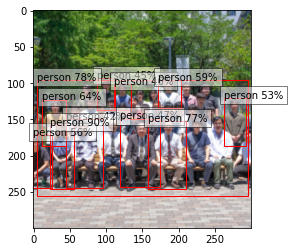

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)

    bboxes, classes, confidences = best_results_per_input[image_idx]
    classes_to_labels = utils.get_coco_object_dictionary()
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()